# CMPU 4048 Environmental Analytics
Dr. Bianca Schoen-Phelan

Lab 5: Spatial Analysis

This lab is for upload!

**Checklist for submission:**
- Complete all cells that are identified by the word Task and a number.
- Download your solution in .ipynb format, and
- Download your solution in .py format, and
- zip both together in a file called ```C12345_EA.zip```, where C12345 is replaced by your student ID.

## **Objective**
This lab checks your ability to perform **core spatial analysis tasks**.
You will:
1. **Download and explore spatial data** for Dublin city.
2. **Perform spatial joins** to link urban features with administrative districts.
3. **Analyse accessibility** by measuring distances between key services.
4. **Visualise spatial patterns** with maps.

## **Context**
This lab will analyse **bus stop accessibility to nursing homes**. It will answer:
- How well are nursing homes served by public transport?
- Which neighbourhoods have the best/worst accessibility?

## **Files**
Upload the provided electoral divisions file provided in brightspace. Alternatively, you can change the code here and mount your google drive instead.

In [1]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 1.5 MB/s eta 0:00:00


In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
from shapely.geometry import Point

In [39]:
# --------------------
# **1. Downloading Data**
# --------------------
print("Downloading city boundary...")
city = ox.geocode_to_gdf("Dublin, Ireland")
city = city.to_crs(epsg=2157)  # Use local CRS for accurate distance calculations

print("Downloading bus stops...")
bus_stops = ox.features_from_place("Dublin, Ireland", tags={"highway": "bus_stop"})
bus_stops = bus_stops.to_crs(epsg=2157)

print("Downloading nursing homes...")
nursing_homes = ox.features_from_place("Dublin, Ireland", tags={"amenity": "nursing_home"})
nursing_homes = nursing_homes.to_crs(epsg=2157)



In [4]:
# Check the types of geometries in nursing_homes
print("Unique geometry types in nursing_homes dataset:", nursing_homes.geometry.type.unique())

Unique geometry types in nursing_homes dataset: ['Point' 'Polygon']


This is something that we need to fix. Many spatial operators are not happy to see mixed geometries in one DataFrame. In this case we will reduce the Polygon down to a point, as we are not interested in the specific shape of a nursing home. We will use the centre of mass of a polygon to convert the Polygon into a Point.

In [5]:
nursing_homes.shape

(22, 25)

In [6]:
# Convert Polygons to their centroids
nursing_homes["geometry"] = nursing_homes.geometry.centroid

In [7]:
print("Unique geometry types in nursing_homes dataset:", nursing_homes.geometry.type.unique())

Unique geometry types in nursing_homes dataset: ['Point']


In [8]:
# Check the types of geometries in bus_stops
print("Unique geometry types in bus_stops dataset:", bus_stops.geometry.type.unique())

Unique geometry types in bus_stops dataset: ['Point']


In [9]:
# Checking that we haven't lost or added anything
nursing_homes.shape

(22, 25)

In [15]:
# load Electoral Divisions from GeoJSON**

print("Loading Electoral Divisions from GeoJSON...")
original_districts = gpd.read_file("/electoral-divisions-dublin.geojson")

# Ensure CRS is correct (transform to EPSG:2157 for Dublin)
original_districts = original_districts.to_crs(epsg=2157)

# Display summary
print(f"Total Electoral Divisions Retrieved: {len(original_districts)}")
original_districts.head()


Loading Electoral Divisions from GeoJSON...
Total Electoral Divisions Retrieved: 162


,DlCnstt,Lcl_E_A,Pllng_D,datstNm,nuts2Nm,county,area,geometry
0,Dublin Bay North,Donaghmede,Ayrfield,Electoral Division,Southern and Eastern,Dublin City,0.893853624053426,"POLYGON ((721092.214 740227.014, 721213.046 74..."
1,Dublin Bay North,Artane-Whitehall,Beaumont B,Electoral Division,Southern and Eastern,Dublin City,0.851095528351093,"POLYGON ((718538.797 739366.148, 718669.012 73..."
2,Dublin Bay North,Artane-Whitehall,Beaumont C,Electoral Division,Southern and Eastern,Dublin City,0.593850627938679,"POLYGON ((719336.168 738998.284, 719644.792 73..."
3,Dublin Bay North,Clontarf,Beaumont D,Electoral Division,Southern and Eastern,Dublin City,0.468887596569626,"POLYGON ((718520.489 738590.605, 718656.973 73..."
4,Dublin Bay North,Clontarf,Beaumont E,Electoral Division,Southern and Eastern,Dublin City,0.314516888770788,"POLYGON ((718098.641 738307.48, 718307.088 738..."


In [16]:
original_districts.shape

(162, 8)

In [17]:
original_districts.columns

Index(['DlCnstt', 'Lcl_E_A', 'Pllng_D', 'datstNm', 'nuts2Nm', 'county', 'area',
       'geometry'],
      dtype='object')

<Axes: >

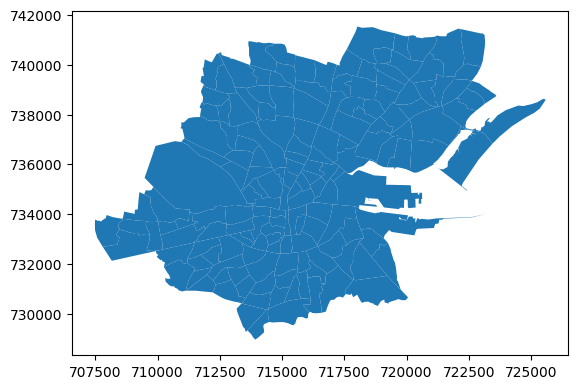

In [18]:
original_districts.plot()

It looks like there are many polygons describing electoral districts. Let's look for duplicates and count.

In [19]:
# Count occurrences of each district before dissolving
district_counts = original_districts["Lcl_E_A"].value_counts()

# Print the unique district names and their counts
print("Unique District Names and Their Counts:\n")
print(district_counts)

# Print the total number of unique district names
print(f"\nTotal Unique Districts: {len(district_counts)}")


Unique District Names and Their Counts:

Lcl_E_A
North Inner City         19
Kimmage-Rathmines        18
Ballymun-Finglas         17
Artane-Whitehall         16
Ballyfermot-Drimnagh     16
Clontarf                 15
South West Inner City    14
Cabra-Glasnevin          14
Donaghmede               12
Pembroke                 11
South East Inner City    10
Name: count, dtype: int64

Total Unique Districts: 11


We only need the name and the geometry.

In [20]:
# Keep only the name and geometry columns, rename name column
districts = original_districts[["Lcl_E_A", "geometry"]]
districts = districts.rename(columns={"Lcl_E_A": "district_name"})

In [21]:
districts

,district_name,geometry
0,Donaghmede,"POLYGON ((721092.214 740227.014, 721213.046 74..."
1,Artane-Whitehall,"POLYGON ((718538.797 739366.148, 718669.012 73..."
2,Artane-Whitehall,"POLYGON ((719336.168 738998.284, 719644.792 73..."
3,Clontarf,"POLYGON ((718520.489 738590.605, 718656.973 73..."
4,Clontarf,"POLYGON ((718098.641 738307.48, 718307.088 738..."
...,...,...
157,North Inner City,"POLYGON ((717221.127 734703.719, 717219.959 73..."
158,North Inner City,"POLYGON ((715902.59 734937.263, 715827.397 734..."
159,North Inner City,"POLYGON ((715260.294 734605.641, 715208.726 73..."
160,Cabra-Glasnevin,"POLYGON ((712121.951 737751.392, 712150.034 73..."


<Axes: >

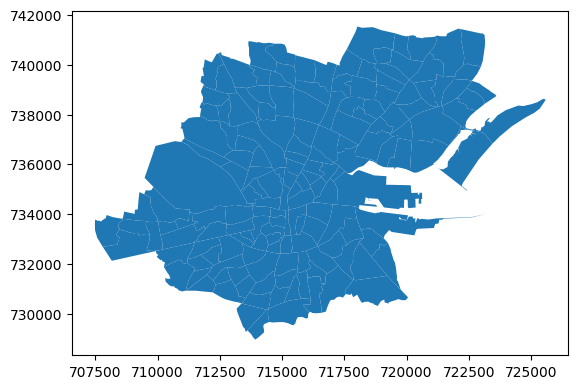

In [22]:
districts.plot()

Before dissolving the geometry. Let's do some checks so that we won't run into any issues later.

In [23]:
# Check for unique geometry types
print("Unique geometry types in districts dataset:", districts.geometry.type.unique())

Unique geometry types in districts dataset: ['Polygon']


Good. We see just one type of geometry. That makes things easier.

In [24]:
# Check 1: Check for missing geometries
missing_geometry_count = districts.geometry.isnull().sum()
print(f"Number of missing geometries: {missing_geometry_count}")

Number of missing geometries: 0


In [25]:
# Check 2: Check for invalid geometries
invalid_geometries = districts[~districts.is_valid]
print(f"Number of invalid geometries: {len(invalid_geometries)}")
if not invalid_geometries.empty:
    print("Invalid districts:")
    print(invalid_geometries[["district_name", "geometry"]])

Number of invalid geometries: 0


In [26]:
# Check 3: Ensure Every Polygon Belongs to a Known District
# Extract expected district names from the dataset
expected_districts = set(districts["district_name"].unique())
# Find unexpected district names
unexpected_districts = set(districts["district_name"].unique()) - expected_districts

print(f"Unexpected district names found: {unexpected_districts}")

Unexpected district names found: set()


In [27]:
# Check 4: Check for missing or blank district names
unnamed_polygons = districts[districts["district_name"].isna() | (districts["district_name"].str.strip() == "")]

# Print how many unnamed polygons exist
print(f"Warning: {len(unnamed_polygons)} polygons have no district name!")

# If any exist, visualize them
if not unnamed_polygons.empty:
    fig, ax = plt.subplots(figsize=(10, 6))
    districts.plot(ax=ax, color="lightgrey", edgecolor="black", alpha=0.5)
    unnamed_polygons.plot(ax=ax, color="red", edgecolor="black", alpha=0.7, label="Unnamed Polygons")
    plt.legend()
    plt.title("Polygons Without a District Name (Before Dissolve)")
    plt.show()


In [28]:
from shapely.ops import unary_union

def find_disconnected_areas(df):
    disconnected_districts = {}

    for district_name in df["district_name"].unique():
        # Extract all geometries of a district
        district_geoms = unary_union(df[df["district_name"] == district_name].geometry)

        # Check if the district consists of multiple disjoint parts
        if district_geoms.geom_type == "MultiPolygon":
            # Further check if the polygons are truly disconnected
            unique_parts = list(district_geoms.geoms)
            disconnected_count = 0

            for i, part in enumerate(unique_parts):
                if not any(part.touches(other) for j, other in enumerate(unique_parts) if i != j):
                    disconnected_count += 1  # Count as disconnected

            if disconnected_count > 1:
                disconnected_districts[district_name] = disconnected_count

    return disconnected_districts

# Run the check
disconnected_areas = find_disconnected_areas(districts)

# Print results
if disconnected_areas:
    print("⚠️ Districts with truly disconnected regions before dissolving:")
    for district, count in disconnected_areas.items():
        print(f"- {district}: {count} separate disconnected parts")
else:
    print("✅ No truly disconnected areas detected before dissolving.")


✅ No truly disconnected areas detected before dissolving.


Very good. We have checked for all we could to make sure that we have a "clean" dataset.

This is very important before a dissolve operation. If any of these had thrown an output, we would have had to fix that first. The dissolve would have still worked but we would have caused strange effects in spatial operations we run later, or worse, **produced wrong facts based on a flawed investigation!**

In [29]:
# Dissolve polygons by district name to merge divisions correctly
dissolved_districts = districts.dissolve(by="district_name").reset_index()

# Display summary
print(f"Total Electoral Divisions Retrieved: {len(dissolved_districts)}")
dissolved_districts

Total Electoral Divisions Retrieved: 11


,district_name,geometry
0,Artane-Whitehall,"POLYGON ((716142.11 737695.853, 715897.36 7377..."
1,Ballyfermot-Drimnagh,"POLYGON ((710291.006 732062.733, 710207.579 73..."
2,Ballymun-Finglas,"POLYGON ((712473.712 737741.391, 712412.958 73..."
3,Cabra-Glasnevin,"POLYGON ((713578.517 734291.989, 713511.626 73..."
4,Clontarf,"POLYGON ((718500.649 736159.937, 718265.54 735..."
5,Donaghmede,"POLYGON ((720641.865 738113.98, 720366.899 737..."
6,Kimmage-Rathmines,"POLYGON ((713430.852 729470.3, 713309.319 7297..."
7,North Inner City,"POLYGON ((716085.875 734433.287, 715978.853 73..."
8,Pembroke,"POLYGON ((717297.763 730684.014, 717194.254 73..."
9,South East Inner City,"POLYGON ((714947.254 732550.94, 714944.225 732..."


We see that the dissolve process has produced a Multipolygon for "Artane-Whitehall". To be save, we will convert the multipolygon into bounds of the largest polygon.

<Axes: >

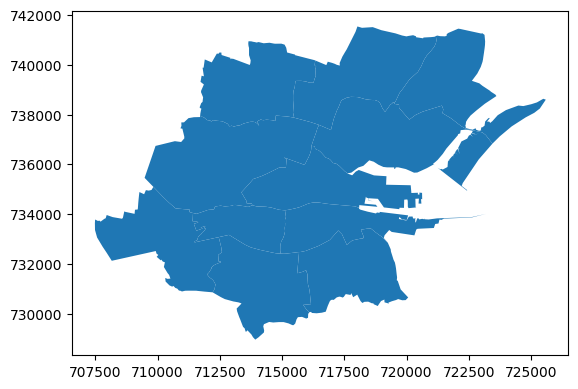

In [30]:
dissolved_districts.plot()

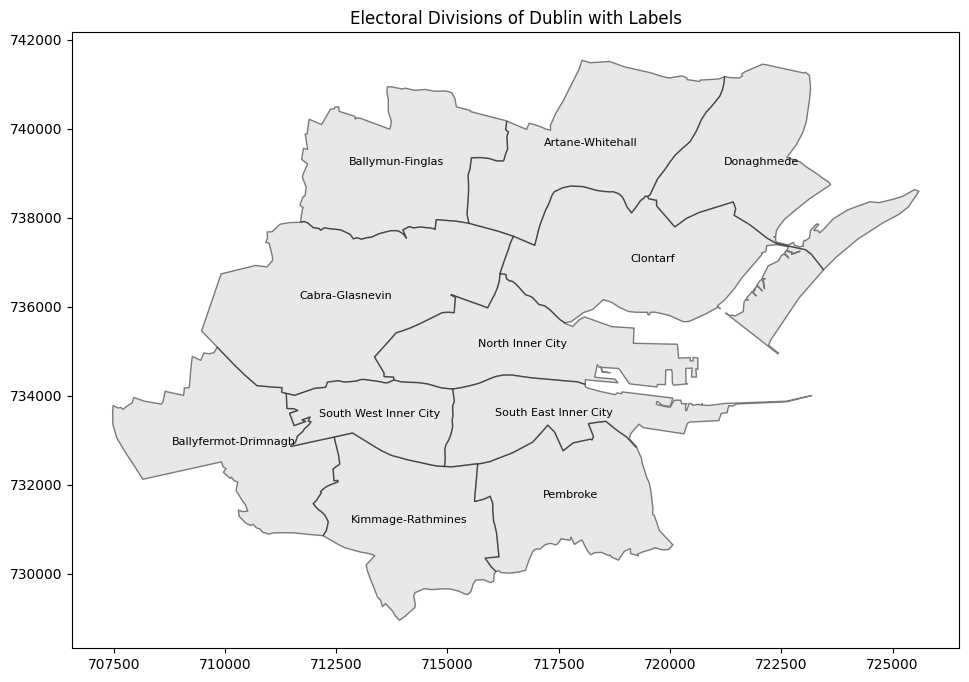

In [31]:
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust figure size as needed

dissolved_districts.plot(ax=ax, color="lightgrey", edgecolor="black", alpha=0.5)

# Add district names as labels
for idx, row in dissolved_districts.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row["district_name"], fontsize=8, ha='center', color='black')

plt.title("Electoral Divisions of Dublin with Labels")
plt.show()

You see that Ballymount Strand in Raheny/Clontarf doesn't have any names on them. You could highlight the polygons to make sure that the island's areas belong to a valid district.

<ipython-input-32-f7678f189c52>:24: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
<ipython-input-32-f7678f189c52>:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


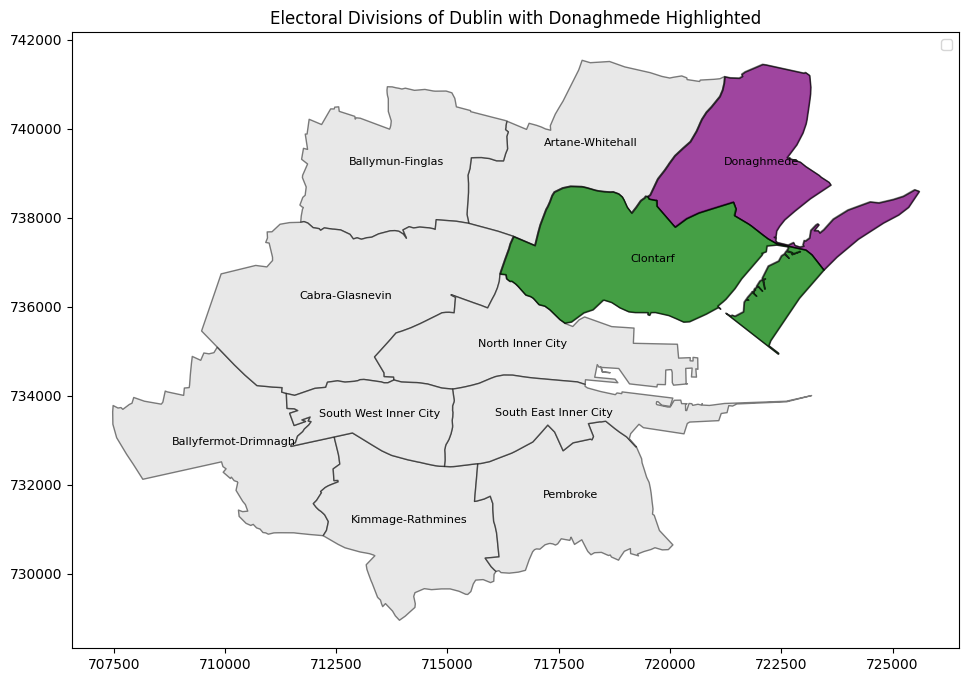

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))  # Adjust figure size as needed

# Plot all districts in light grey
dissolved_districts.plot(ax=ax, color="lightgrey", edgecolor="black", alpha=0.5)

# Highlight Donaghmede in purple
dissolved_districts[dissolved_districts["district_name"] == "Donaghmede"].plot(
    ax=ax, color="purple", edgecolor="black", alpha=0.7, label="Donaghmede"
)

# Highlight Clontarf in green
dissolved_districts[dissolved_districts["district_name"] == "Clontarf"].plot(
    ax=ax, color="green", edgecolor="black", alpha=0.7, label="Clontarf"
)

# Add district names as labels
for idx, row in dissolved_districts.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row["district_name"], fontsize=8, ha="center", color="black")

plt.title("Electoral Divisions of Dublin with Donaghmede Highlighted")
plt.legend()
plt.show()


We see that the island is divided but belongs to administrative units Clontarf and Donaghmede respectively.

Historically, electoral units are being moved and change names. A map is a represenation of fact of a specific point in time. This map is for 2022.

# **2. Data Exploration**



<Axes: >

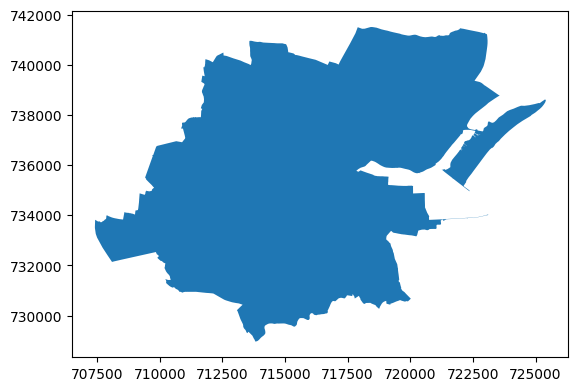

In [33]:
city.plot()

<Axes: >

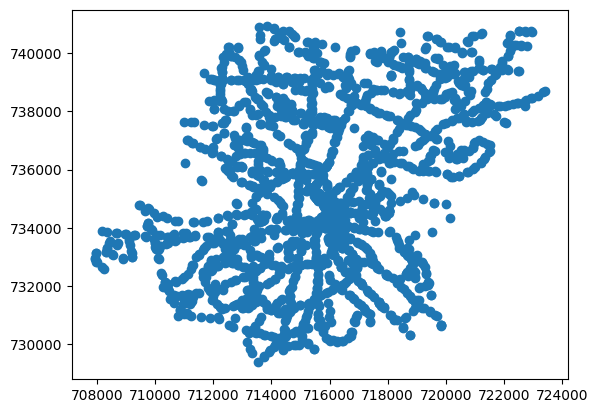

In [34]:
bus_stops.plot()

<Axes: >

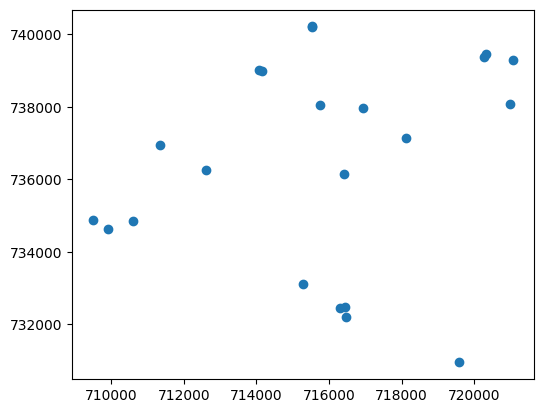

In [35]:
nursing_homes.plot()

# Task 1

As part of Exploratory Spatial Data Analysis, perform a KDE on the distribution of nursing homes across Dublin City.

**Steps:**
1. Extract x and y coordinates from the ```nursing_homes``` dataframe.
2. Create the [```sns.kdeplot()```](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) using these x and y values.
3. Use the city dataframe as a backdrop.
4. Also visualise the original nursing_home dataframe in this plot.
5. Use appropriate legend and title.

In [37]:
import seaborn as sns

In [58]:
# Download city boundary
print("Downloading city boundary...")
city = ox.geocode_to_gdf("Dublin, Ireland")
city = city.to_crs(epsg=2157)  # Use local CRS for accurate distance calculations

# Download bus stops
print("Downloading bus stops...")
bus_stops = ox.features_from_place("Dublin, Ireland", tags={"highway": "bus_stop"})
bus_stops = bus_stops.to_crs(epsg=2157)

# Download nursing homes
print("Downloading nursing homes...")
nursing_homes = ox.features_from_place("Dublin, Ireland", tags={"amenity": "nursing_home"})
nursing_homes = nursing_homes.to_crs(epsg=2157)

# Convert Polygons to their centroids
nursing_homes["geometry"] = nursing_homes.geometry.centroid

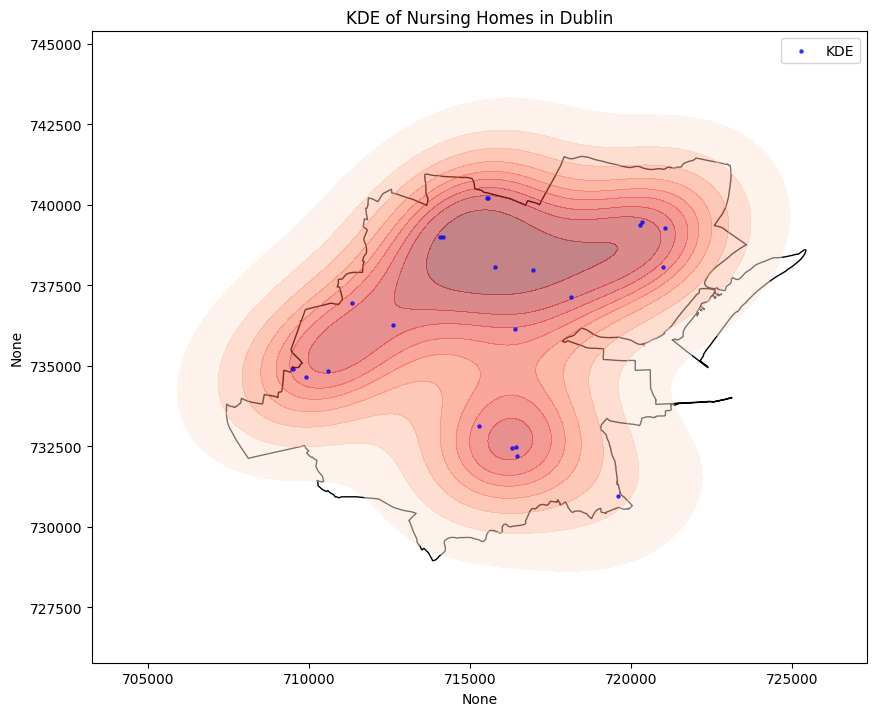

In [59]:
# Extract x and y coordinates from the nursing_homes dataframe
x = nursing_homes.geometry.x
y = nursing_homes.geometry.y

# Plot KDE
fig, ax = plt.subplots(figsize=(10, 10))
city.plot(ax=ax, color='white', edgecolor='black')
sns.kdeplot(x=x, y=y, ax=ax, cmap='Reds', fill=True, alpha=0.5)
nursing_homes.plot(ax=ax, color='blue', markersize=5, alpha=0.7)
plt.title("KDE of Nursing Homes in Dublin")
plt.legend(['KDE', 'Nursing Homes'])
plt.show()

# **3. Spatial Analysis Tasks**

## **Task 2: Assigning Nursing Homes to Districts**

Using a spatial join, determine how many nursing homes exist in each administrative district.

**Steps:**
1. Perform the spatial join. Remember about the purpose of reindexing after a join operation. You can use [```.size()```](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.size.html#pandas.core.groupby.DataFrameGroupBy.size) to count rows in each district group. [```reindex(dissolved_districts["district_name"], fill_value=0)``` ](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reindex.html) will show districts even if they have 0 counts.
2. Verify that no geometries went missing during the join by checking that there are no geometry entries of the new dataframe that are null. Also verify that when it shows your count, your join hasn't produced more nursing homes. We have 22 nursing homes.
3. Check the shape and entries in your new dataframe.
4. Make sure that there is a value for every one of the 11 electoral divisions. Your output should look similar to:
```
Nursing Homes per District:
district_name
Artane-Whitehall         2
Ballyfermot-Drimnagh     2
Ballymun-Finglas         4
Cabra-Glasnevin          3
Clontarf                 2
Donaghmede               3
Kimmage-Rathmines        0
North Inner City         1
Pembroke                 4
South East Inner City    1
South West Inner City    0
```


In [57]:
districts = original_districts.to_crs(epsg=2157)
districts = districts.rename(columns={"Lcl_E_A": "district_name"})
nursing_homes_in_districts = gpd.sjoin(nursing_homes, districts, how="inner", predicate="intersects")

nursing_homes_per_district = nursing_homes_in_districts.groupby("district_name").size().reset_index(name='count')

print("Nursing Homes per District:")
print(nursing_homes_per_district)

Nursing Homes per District:
           district_name  count
0       Artane-Whitehall      2
1   Ballyfermot-Drimnagh      2
2       Ballymun-Finglas      4
3        Cabra-Glasnevin      3
4               Clontarf      2
5             Donaghmede      3
6       North Inner City      1
7               Pembroke      4
8  South East Inner City      1


That's good. Although there are some names missing, all geometries are there. Although this is not always the case, for this investigation we are going to assume that the nursing home still exists (as there is a geometry for it), and that the dataset is just missing the name. This is an assumption that would have to be verified!

## **Task 3: Identifying Nursing Homes Lacking Nearby Bus Stops**
A nursing home is considered **poorly served** if the nearest bus stop is **more than 300m away**.

**Steps:**
1. Create a function called ```find_nearest(point, other_points)``` that uses the [```distance(...)```](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.distance.html) function to calculate the distance between a specific point and a geometry column. The return value of this function should come from ```.idxmin()```, applied to the outcome of distance, which finds the index of the nearest bus stop (i.e., the one with the smallest distance).
2. Create a two new columns in your ```nursing_homes``` dataframe. One called ```nearest_bus_stops``` and one called ```distance_to_bus_stop```. Using .apply() and lambda if you find them helpful (or just a regular loop) to fill these columns. To do that use your new function called ```find_nearest``` to populate ```nearest_bus_stops``` and use ```row: row.geometry.distance(bus_stops.loc[row["nearest_bus_stop"], "geometry"]), axis=1)``` to populate ```distance_to_bus_stop``` with apply and lambda (or just a regular loop).
3. Then you can identify poorly served nursing homes by checking for nursinghomes, where the ```distance_to_bus_stop``` is larger than 300 metres. Your result should find 2 nursing homes.

In [66]:
def find_nearest(point, other_points):
    distances = other_points.distance(point)
    nearest_index = distances.idxmin()
    return nearest_index

nursing_homes = nursing_homes.to_crs(epsg=2157)
bus_stops = bus_stops.to_crs(epsg=2157)

# Apply function to get nearest bus stop index
nursing_homes["nearest_bus_stop"] = nursing_homes.geometry.apply(
    lambda geom: find_nearest(geom, bus_stops.geometry)
)

# Calculate distances using stored index
nursing_homes["distance_to_bus_stop"] = nursing_homes.apply(
    lambda row: row.geometry.distance(bus_stops.loc[row["nearest_bus_stop"], "geometry"]),
    axis=1
)

# Identify poorly served nursing homes (distance > 300 meters)
poorly_served_nursing_homes = nursing_homes[nursing_homes["distance_to_bus_stop"] > 300]

print("Poorly served nursing homes:")
print(poorly_served_nursing_homes)

Poorly served nursing homes:
                                        geometry addr:street       amenity  \
element id                                                                   
way     120086080  POINT (710581.105 734840.402)         NaN  nursing_home   
        967981249  POINT (716402.252 736159.545)         NaN  nursing_home   

                  email  fax                 name phone social_facility  \
element id                                                                
way     120086080   NaN  NaN  Cara Cheshire House   NaN             NaN   
        967981249   NaN  NaN                  NaN   NaN             NaN   

                  social_facility:for website  ... addr:postal_district  \
element id                                     ...                        
way     120086080                 NaN     NaN  ...                  NaN   
        967981249                 NaN     NaN  ...                  NaN   

                  emergency addr:housename operator old_

## **Task 4: Visualising Results**

Plot your poorly served nursing homes. Try to recreate something that looks similar to the following image:

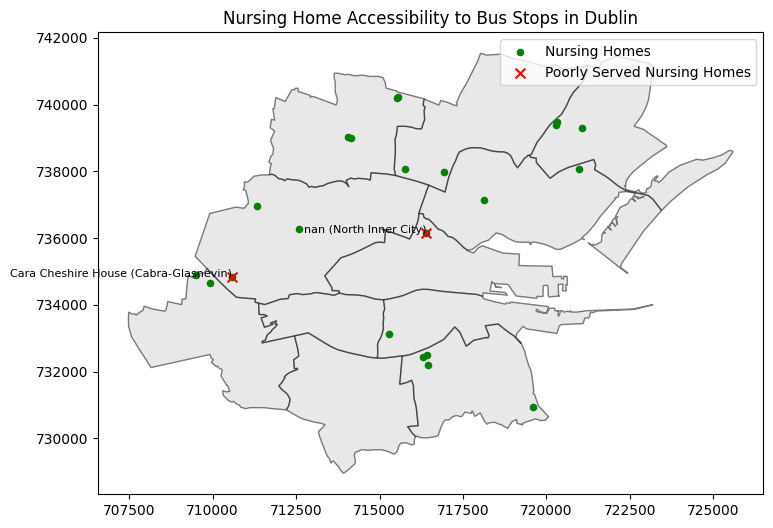



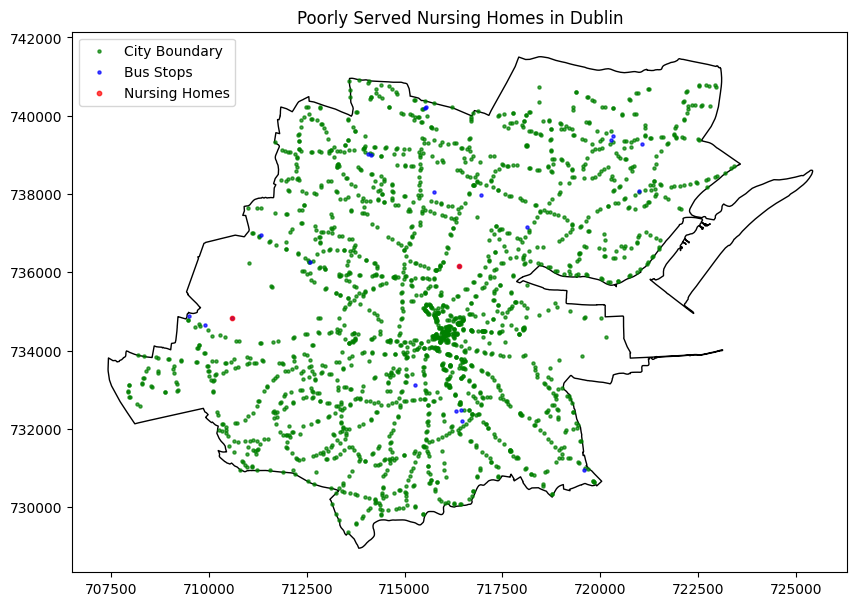

In [67]:
fig, ax = plt.subplots(figsize=(10, 10))
city.plot(ax=ax, color='white', edgecolor='black')
bus_stops.plot(ax=ax, color='green', markersize=5, alpha=0.7)
nursing_homes.plot(ax=ax, color='blue', markersize=5, alpha=0.7)
poorly_served_nursing_homes.plot(ax=ax, color='red', markersize=10, alpha=0.7)

plt.title("Poorly Served Nursing Homes in Dublin")
plt.legend(['City Boundary', 'Bus Stops', 'Nursing Homes', 'Poorly Served Nursing Homes'])
plt.show()

We see that one of the poorly served nursing homes is also missing a name - that was our problem from earlier.

## Task 5: Does it exist?

Using some investigative abilities (use google and google maps), do you think nan is valid for one of the poorly served nursing homes? If so, remove it. If not, re-assign the name value.

**Hint:** CRS matter! And what element is your longitude and which one is your latitude?

In [69]:
print("Poorly served nursing homes with missing names:")
print(poorly_served_nursing_homes[poorly_served_nursing_homes['name'].isnull()])

poorly_served_nursing_homes.loc['way     967981249', 'name'] = 'Updated Name'

poorly_served_nursing_homes = poorly_served_nursing_homes.dropna(subset=['name'])

print("Updated poorly served nursing homes:")
print(poorly_served_nursing_homes)

Poorly served nursing homes with missing names:
                                        geometry addr:street       amenity  \
element id                                                                   
way     967981249  POINT (716402.252 736159.545)         NaN  nursing_home   

                  email  fax name phone social_facility social_facility:for  \
element id                                                                    
way     967981249   NaN  NaN  NaN   NaN             NaN                 NaN   

                  website  ... addr:postal_district emergency addr:housename  \
element id                 ...                                                 
way     967981249     NaN  ...                  NaN       NaN            NaN   

                  operator old_name operator:type type roof:shape  \
element id                                                          
way     967981249      NaN      NaN           NaN  NaN        NaN   

                     nearest_b

<ipython-input-69-6e22f734537b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poorly_served_nursing_homes.loc['way     967981249', 'name'] = 'Updated Name'


# This Analysis' Highlights

- The distribution of nursing homes across administrative districts.
- The extent to which nursing homes are served by public transportation.
- Potential gaps in transport planning where accessibility can be improved.

## Task 6: Voronoi

Create a voronoi diagram. Your input points are all nursing homes.

**Steps:**
1. Convert your nursing home into a numpy array using ```np.array(list(zip(nursing_homes.geometry.x, nursing_homes.geometry.y)))``` and assign this to a variable.
2. Use this numpy array as input to the [```Voronoi(...)```](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Voronoi.html) function.
3. Plot the voronoi over the your dissolved districts using [```voronoi_plot_2d```](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.voronoi_plot_2d.html).
4. Also show all nursing home points in this visualisation.

In [49]:
import numpy as np  # Import the numpy library and alias it as 'np'
from scipy.spatial import Voronoi, voronoi_plot_2d # Import Voronoi and voronoi_plot_2d


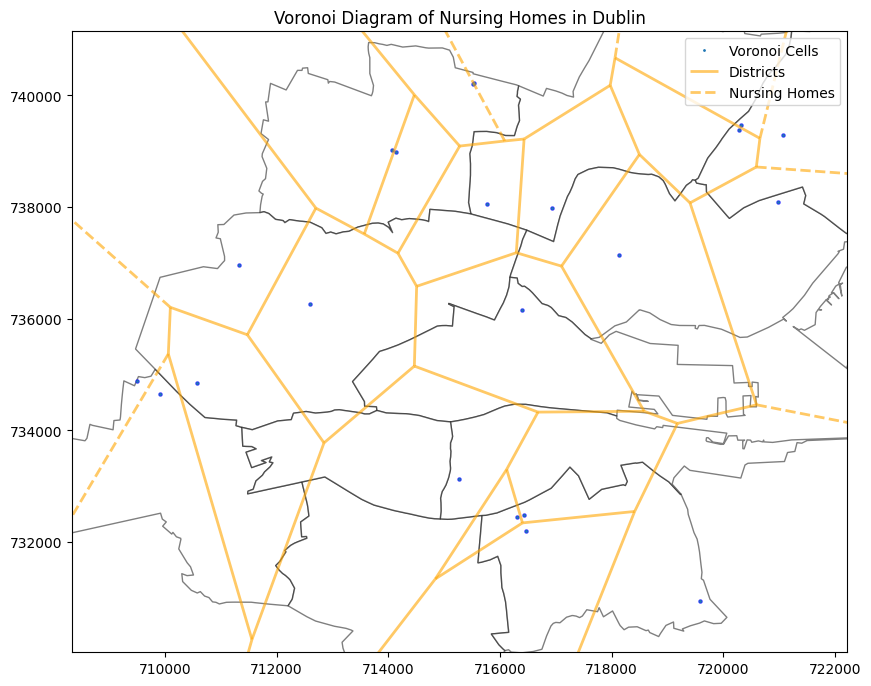

In [68]:
# Task 6: Voronoi Diagram

points = np.array(list(zip(nursing_homes.geometry.x, nursing_homes.geometry.y)))

vor = Voronoi(points)


fig, ax = plt.subplots(figsize=(10, 10))
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='orange', line_width=2, line_alpha=0.6, point_size=2)
dissolved_districts.plot(ax=ax, color='white', edgecolor='black', alpha=0.5)
nursing_homes.plot(ax=ax, color='blue', markersize=5, alpha=0.7)
plt.title("Voronoi Diagram of Nursing Homes in Dublin")
plt.legend(['Voronoi Cells', 'Districts', 'Nursing Homes'])
plt.show()

## Understanding the Lack of Overlap Between Voronoi Cells and Districts

The Voronoi cells represent areas closest to a given nursing home, while the districts represent administrative boundaries. The lack of overlap suggests that nursing home accessibility does not align with administrative divisions.

**Implications for Resourcing and Planning:**

- 1️⃣ District-Based Resource Allocation May Not Reflect Real Accessibility Needs:
Governments and policymakers typically allocate healthcare resources based on administrative districts.
However, people do not necessarily use services within their district—they may travel across districts to access the nearest nursing home.
Implication: Funding and staffing decisions based purely on district boundaries may not match actual service usage.

- 2️⃣ Large Voronoi Cells Indicate Service Gaps, Regardless of District Boundaries:
If a single Voronoi cell is large, that means a nursing home serves a disproportionately large area.
However, if this cell spans multiple districts, the responsibility for care may be unclear.
Implication: Some districts may appear well-resourced on paper but actually rely on facilities in neighboring districts.

- 3️⃣ Districts With No Nursing Homes May Be Overlooked in Planning:
Some districts may have no nursing homes at all, even if their population requires them.
Since Voronoi analysis ignores district boundaries, it highlights where service coverage is actually lacking, rather than just looking at administrative allocations.
Implication: If funding decisions are based on district-level data rather than actual accessibility, underserved areas might be missed.

- 4️⃣ Public Transport and Infrastructure Planning Must Consider Actual Accessibility:
If nursing homes do not align with district boundaries, then public transport routes should not either.
Implication: Bus routes, walking paths, and accessibility planning should be based on Voronoi-based catchment areas, not just district-level transport planning.